In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-05-07',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-12-11,27.750,30.1600,27.510,28.97,20484956.0
2024-12-12,28.900,29.6592,28.580,28.75,8855674.0
2024-12-13,28.700,28.8600,27.922,27.99,6581586.0
2024-12-16,27.700,29.5900,27.270,29.44,8700033.0
2024-12-17,29.635,31.8800,29.635,31.26,19948086.0
...,...,...,...,...,...
2025-05-01,27.980,28.3500,27.415,27.43,5693525.0
2025-05-02,27.700,27.9163,27.150,27.48,5579861.0
2025-05-05,27.325,27.4100,26.350,26.60,7132359.0
2025-05-06,26.440,26.5000,25.665,26.04,5883843.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-12-11    1
2024-12-12    1
2024-12-13    1
2024-12-16    1
2024-12-17    1
             ..
2025-05-01    1
2025-05-02    1
2025-05-05    1
2025-05-06    1
2025-05-07    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

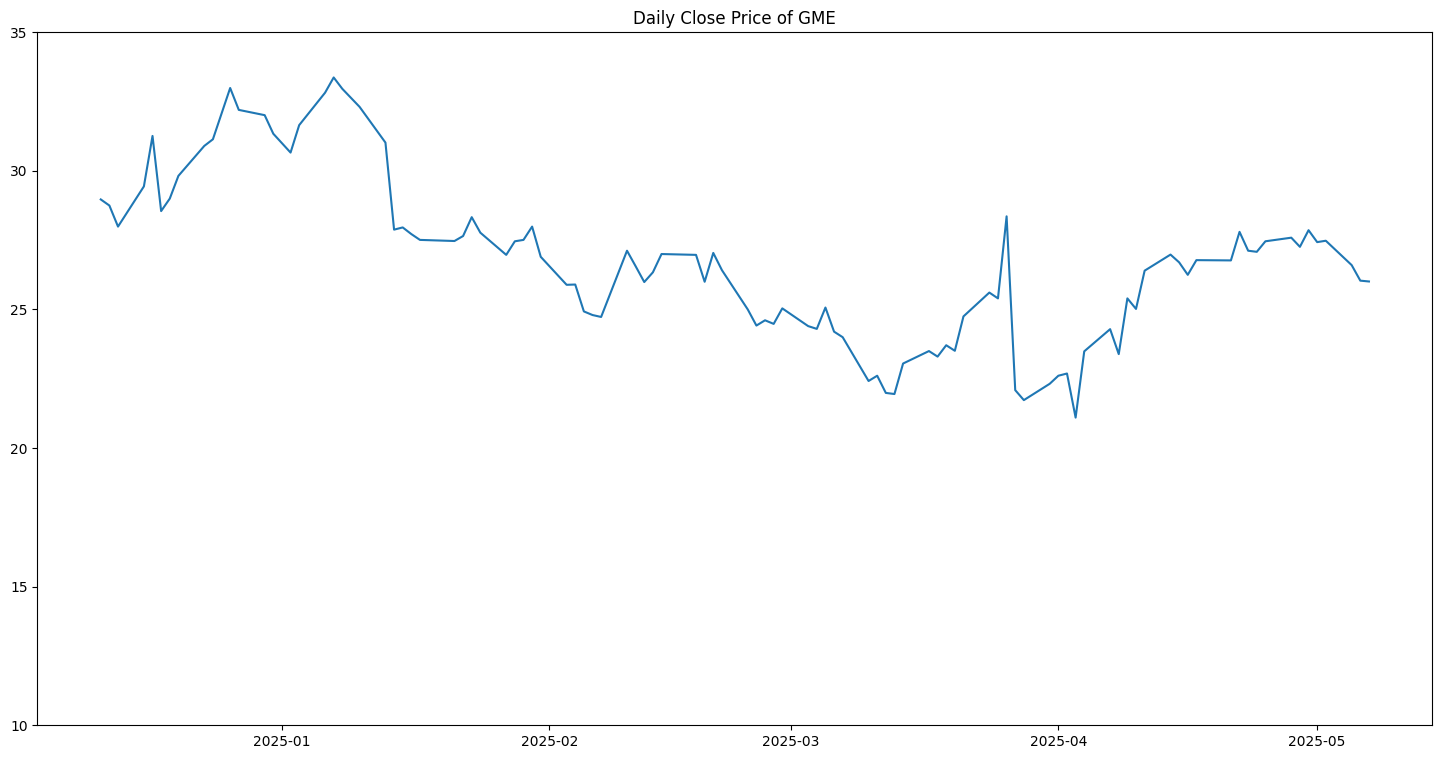

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

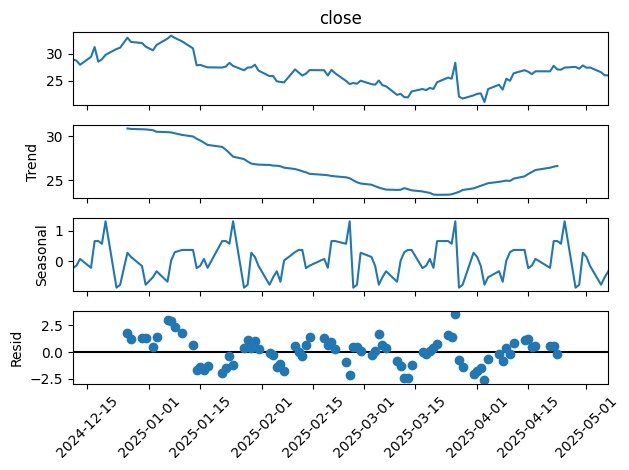

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': "Billionaire Bill Ackman Thinks Hertz Stock Could Reach $30 by the End of the Decade. Here's Why It Could Happen Sooner Than That.",
  'url': 'https://www.fool.com/investing/2025/05/06/billionaire-bill-ackman-thinks-hertz-stock-could-1/',
  'time_published': '20250506T140700',
  'authors': ['Adam Spatacco'],
  'summary': 'Certain personalities on Wall Street have the influence to create major moves in a stock with a simple comment or social media post. Billionaire hedge fund manager Bill Ackman is one of those people.A couple of weeks ago, Ackman posted on X ( previously known as Twitter ) that his investment ...',
  'banner_image': 'https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F816990%2Fgettyimages-1472673456.jpg&op=resize&w=700',
  'source': 'Motley Fool',
  'category_within_source': 'n/a',
  'source_domain': 'www.fool.com',
  'topics': [{'topic': 'Earnings', 'relevance_score': '0.495866'},
   {'topic': 'Retail & Wholesale', 'relevance

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,Billionaire Bill Ackman Thinks Hertz Stock Cou...,20250506T140700,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
1,Stephan Tetrault Acquires GameStop Canada,20250505T201500,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
2,Here is What to Know Beyond Why GameStop Corp....,20250505T130012,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
3,Looking Into GameStop's Recent Short Interest ...,20250502T130037,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral
4,If You Invested $1000 In This Stock 5 Years Ag...,20250430T164515,Benzinga Insights,GameStop GME has outperformed the market over ...,Benzinga,0.250000,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.941873,0.382786,Bullish
5,"Growth of crypto poses risks to investors, fin...",20250429T215049,Christopher Tepedino,The Bank of Italy identified Bitcoin and other...,Cointelegraph,0.096367,Neutral,"Life Sciences, Retail & Wholesale, Technology,...",GME,0.116914,0.21946,Somewhat-Bullish
6,GameStop ( GME ) Exceeds Market Returns: Som...,20250428T214517,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
7,GameStop Stakeholders Are Not Aligned on Bitco...,20250425T181225,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
8,Should You Invest in Bitcoin Now?,20250425T174500,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral
9,GameStop Gets Nintendo Switch 2 Boost: Should ...,20250425T142740,Surbhi Jain,GameStop offers up to $175 off Switch 2 preord...,Benzinga,0.410144,Bullish,"Retail & Wholesale, Financial Markets",GME,0.830869,0.66996,Bullish


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Adam Spatacco', 'PRNewswire', 'Zacks Equity Research',
       'Benzinga Insights', 'Christopher Tepedino', 'André Beganski',
       'Andrew Rocco', 'Surbhi Jain', 'Brayden Lindrea', 'Brian Bolan',
       'Adam Eckert', 'Henry Khederian', 'Globe Newswire',
       'Bram Berkowitz', 'Rishabh Mishra', 'Vaishali Prayag',
       'Aniket Verma', 'Motley Fool Staff', 'Stephen Katte',
       'Derek Lewis', 'Ritujay Ghosh', 'Sanghamitra Saha', 'Nalak Das',
       'Akanksha Bakshi', 'Murtuza J Merchant', 'Proiti Seal Acharya',
       'Alex O’Donnell', '', 'Liz Napolitano', 'Sam Bourgi'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-06,Billionaire Bill Ackman Thinks Hertz Stock Cou...,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
2025-05-05,Stephan Tetrault Acquires GameStop Canada,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
2025-05-05,Here is What to Know Beyond Why GameStop Corp....,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
2025-05-02,Looking Into GameStop's Recent Short Interest ...,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral
2025-04-30,If You Invested $1000 In This Stock 5 Years Ag...,Benzinga Insights,GameStop GME has outperformed the market over ...,Benzinga,0.250000,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.941873,0.382786,Bullish
2025-04-29,"Growth of crypto poses risks to investors, fin...",Christopher Tepedino,The Bank of Italy identified Bitcoin and other...,Cointelegraph,0.096367,Neutral,"Life Sciences, Retail & Wholesale, Technology,...",GME,0.116914,0.21946,Somewhat-Bullish
2025-04-28,GameStop ( GME ) Exceeds Market Returns: Som...,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
2025-04-25,GameStop Stakeholders Are Not Aligned on Bitco...,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
2025-04-25,Should You Invest in Bitcoin Now?,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral


In [24]:
news.groupby(news.index.date).size()

2025-04-04    2
2025-04-07    4
2025-04-08    5
2025-04-09    1
2025-04-10    2
2025-04-11    4
2025-04-14    2
2025-04-15    1
2025-04-16    2
2025-04-17    2
2025-04-18    1
2025-04-21    1
2025-04-22    2
2025-04-23    4
2025-04-24    5
2025-04-25    5
2025-04-28    1
2025-04-29    1
2025-04-30    1
2025-05-02    1
2025-05-05    2
2025-05-06    1
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-04-07,Crypto veterans seek to make publicly traded J...,,A small publicly traded software company is lo...,CNBC,0.300048,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.051441,0.106461,Neutral


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-06,Billionaire Bill Ackman Thinks Hertz Stock Cou...,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
2025-05-05,Stephan Tetrault Acquires GameStop Canada,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
2025-05-05,Here is What to Know Beyond Why GameStop Corp....,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
2025-05-02,Looking Into GameStop's Recent Short Interest ...,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral
2025-04-30,If You Invested $1000 In This Stock 5 Years Ag...,Benzinga Insights,GameStop GME has outperformed the market over ...,Benzinga,0.250000,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.941873,0.382786,Bullish
2025-04-29,"Growth of crypto poses risks to investors, fin...",Christopher Tepedino,The Bank of Italy identified Bitcoin and other...,Cointelegraph,0.096367,Neutral,"Life Sciences, Retail & Wholesale, Technology,...",GME,0.116914,0.21946,Somewhat-Bullish
2025-04-28,GameStop ( GME ) Exceeds Market Returns: Som...,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
2025-04-25,GameStop Stakeholders Are Not Aligned on Bitco...,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
2025-04-25,Should You Invest in Bitcoin Now?,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Bullish', 'Neutral'], dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Neutral', 'Bullish', 'Somewhat-Bullish', 'Somewhat-Bearish'],
      dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_15700\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_15700\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-11,27.750,30.1600,27.510,28.97,20484956.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-12,28.900,29.6592,28.580,28.75,8855674.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-13,28.700,28.8600,27.922,27.99,6581586.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-16,27.700,29.5900,27.270,29.44,8700033.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-17,29.635,31.8800,29.635,31.26,19948086.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02,27.700,27.9163,27.150,27.48,5579861.0,Looking Into GameStop's Recent Short Interest ...,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,4.0,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,3.0
2025-05-05,27.325,27.4100,26.350,26.60,7132359.0,Stephan Tetrault Acquires GameStop Canada,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,5.0,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,5.0
2025-05-05,27.325,27.4100,26.350,26.60,7132359.0,Here is What to Know Beyond Why GameStop Corp....,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,4.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,4.0
2025-05-06,26.440,26.5000,25.665,26.04,5883843.0,Billionaire Bill Ackman Thinks Hertz Stock Cou...,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,4.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,3.0


In [31]:
merged_df.dtypes

open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
title                       object
authors                     object
summary                     object
source                      object
overall_sentiment_score    float64
overall_sentiment_label    float64
topics                      object
ticker                      object
ticker_relevance_score      object
ticker_sentiment_score      object
ticker_sentiment_label     float64
dtype: object

In [32]:
merged_df['ticker_relevance_score'] = merged_df['ticker_relevance_score'].astype(float)
merged_df['ticker_sentiment_score'] = merged_df['ticker_sentiment_score'].astype(float)

In [33]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','authors','summary','source'])
merged_df

,open,high,low,close,volume,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-11,27.750,30.1600,27.510,28.97,20484956.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-12,28.900,29.6592,28.580,28.75,8855674.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-13,28.700,28.8600,27.922,27.99,6581586.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-16,27.700,29.5900,27.270,29.44,8700033.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-17,29.635,31.8800,29.635,31.26,19948086.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-02,27.700,27.9163,27.150,27.48,5579861.0,0.294277,4.0,0.205807,0.148288,3.0
2025-05-05,27.325,27.4100,26.350,26.60,7132359.0,0.367348,5.0,0.584328,0.529335,5.0
2025-05-05,27.325,27.4100,26.350,26.60,7132359.0,0.264318,4.0,0.526867,0.185794,4.0
2025-05-06,26.440,26.5000,25.665,26.04,5883843.0,0.167199,4.0,0.049835,0.061950,3.0


## LSTM Model

In [34]:
# Split off target
features = merged_df.drop(columns=['close'])
target = merged_df[['close']]

# Normalize
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Reassemble DataFrame
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
scaled_df['close'] = target_scaled

In [35]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)
look_back = 10
X, y = create_lstm_dataset(scaled_df, target_column='close', look_back=look_back)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False)

In [37]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    Dropout(0.1),
    LSTM(50, return_sequences=False),
    Dropout(0.1),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.2211 - val_loss: 0.0248
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0548 - val_loss: 0.0046
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0582 - val_loss: 0.0173
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234 - val_loss: 0.0385
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0308 - val_loss: 0.0452
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0276 - val_loss: 0.0406
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0269 - val_loss: 0.0371
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0263 - val_loss: 0.0453
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0257 - val_loss: 0.0526
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0229 - val_loss: 0.0515
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - val_loss: 0.0384
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0237 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


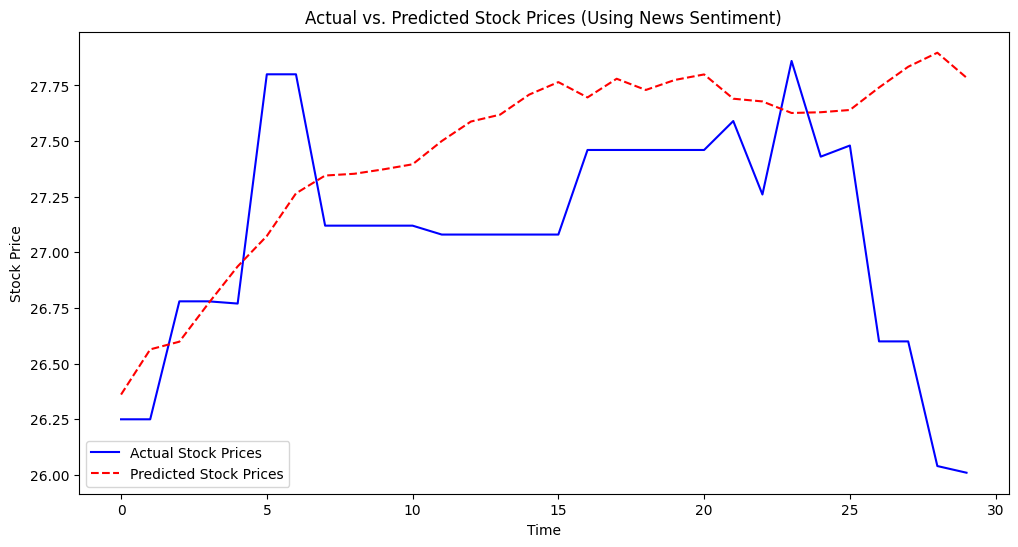

In [40]:
y_pred = model.predict(X_test)
y_pred_unscaled = target_scaler.inverse_transform(y_pred)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Stock Prices", color="blue")
plt.plot(y_pred_unscaled, label="Predicted Stock Prices", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (Using News Sentiment)")
plt.legend()
plt.show()